<a href="https://colab.research.google.com/github/filipp134/Telegram-bot-TMDB-movies/blob/main/TMDB_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Устанавливаяться библиотека python-telegram-bot
!pip install python-telegram-bot python-telegram-bot

     |████████████████████████████████| 440kB 6.1MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 


In [ ]:
import requests
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters
import logging
from datetime import date, timedelta
from telegram import InlineKeyboardButton, InlineKeyboardMarkup, Update
from telegram.ext import Updater, CommandHandler, CallbackQueryHandler, CallbackContext

TOKEN = '1548279453:AAH3pAQNNoKA8GeYr8Zx674DlXxAitPmm3g'
API_KEY = 'e3bd30e9ec6db1013021ef223e7b39ae'
API_LINK = 'https://api.themoviedb.org/3'

In [ ]:
#Функция, выполняющаяся при вызове команды /start
def start(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text="I'm a bot, please talk to me!")

In [ ]:
keyboard = []
def trending(update: Update, context: CallbackContext) -> None:
    ''' Получение топа фильмов по популярности из TMDB в России для телеграм-бота.  '''
    payload = {
        'api_key': API_KEY,
        'region': 'RU', 
        'sort_by': 'popularity.desc',
        'primary_release_date.gte': (date.today() - timedelta(days=14)).isoformat(),
        'primary_release_date.lte': date.today().isoformat(),
        'language': 'ru',
    }
    trends = requests.get(f'{API_LINK}/discover/movie', params=payload).json()
    i = 1
    keyboard = []
    for film in trends['results']:
        # Здесь отформатировал вывод программы
        trend_info = (
            f'{i}. {film["title"]}\n'
            f'{film["release_date"]} | {film["original_language"]} | {str(film["vote_average"])}\n'
            f'{film["overview"]}'
        )
        i += 1
        # keyboard = InlineKeyboardButton(trend_info, callback_data=film['title'])
        context.bot.send_message(chat_id=update.effective_chat.id, text=trend_info)
        # reply_markup = InlineKeyboardMarkup(keyboard)
        # editMessageReplyMarkup(chat_id = update.effective_chat.id, message_id = None,
        #                        inline_message_id = NULL, reply_markup = reply_markup)
        # print(keyboard)
        # keyboard = []
#    reply_markup = InlineKeyboardMarkup(keyboard)
#    update.message.reply_text('You can discover the films:', reply_markup=reply_markup)

In [ ]:
def find_film(update, context):
    movie_name = update.message.text
    payload = {
        'api_key': API_KEY,
        'query': movie_name,
    }
    film_info = requests.get(f'{API_LINK}/search/movie', params=payload).json()
    for film in film_info['results']:
        movie_info = (
            f"{film_info['results'].index(film) + 1}. {film['title']}\n"
            f"{film['release_date']} | {film['original_language']} | {str(film['vote_average'])}\n"
            f"{film['overview']}"
        )
        context.bot.send_message(chat_id=update.effective_chat.id, text=movie_info)
 #   context.bot.send_message(chat_id=update.effective_chat.id, text=update.message.text)

In [ ]:
def button(update: Update, context: CallbackContext) -> None:
    query = update.callback_query
    # CallbackQueries need to be answered, even if no notification to the user is needed
    # Some clients may have trouble otherwise. See https://core.telegram.org/bots/api#callbackquery
    query.answer()
    query.edit_message_text(text=f"Selected option: {query.data}")

In [ ]:
def main():
    #Создаётся журнал logging
    logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                      level=logging.INFO)
    #Создаётся Updater и Dispatcher
    updater = Updater(token=TOKEN, use_context=True) 
    dispatcher = updater.dispatcher
    start_handler = CommandHandler('start', start)
    dispatcher.add_handler(start_handler)
    trending_handler = CommandHandler('trending', trending)
    dispatcher.add_handler(trending_handler)
    print(type(updater))
    print(keyboard)
    # updater.dispatcher.add_handler(CallbackQueryHandler(button))
    film_handler = MessageHandler(Filters.text & (~Filters.command), find_film)
    dispatcher.add_handler(film_handler)
    updater.start_polling()
#if __name__ == "__main__":
main()

2021-01-31 21:04:28,301 - apscheduler.scheduler - INFO - Scheduler started


<class 'telegram.ext.updater.Updater'>
[]


In [ ]:
!pip install python-telegram-bot python-telegram-bot
from datetime import date, timedelta, datetime
import requests
from telegram import InlineKeyboardButton, InlineKeyboardMarkup, Update, ParseMode
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackQueryHandler, CallbackContext, \
    ConversationHandler

TOKEN = '1548279453:AAH3pAQNNoKA8GeYr8Zx674DlXxAitPmm3g'
API_KEY = 'e3bd30e9ec6db1013021ef223e7b39ae'
API_LINK = 'https://api.themoviedb.org/3'
IMAGES_LINK = 'https://image.tmdb.org/t/p/original'
MOVIE_LINK = 'https://www.themoviedb.org/movie/'
SEARCH_LIST, TRENDING_LIST, CREATE_SESSION, WORK_WITH_LISTS, ADD_MOVIE_TO_LIST = range(5)
PREV, NEXT = range(2)
HEADERS = {'Content-Type': 'application/json;charset=utf-8'}

def keyboard_forward_backward():
    """Генерируем инлайн клавиатуру"""
    keyboard = [
        [
            InlineKeyboardButton("<", callback_data=str(PREV)),
            InlineKeyboardButton(">", callback_data=str(NEXT)),
        ]
    ]
    return InlineKeyboardMarkup(keyboard)

def keyboard_to_list(context):
    """Генерируем инлайн клавиатуру"""
    keyboard = [
        [
            InlineKeyboardButton("Добавить в список", callback_data=str(context.user_data('list_id'))),
        ]
    ]
    return InlineKeyboardMarkup(keyboard)

def keyboard_creation_or_existing():
    keyboard = [
        [
            InlineKeyboardButton("Create the new one.", switch_inline_query_current_chart='create_list'),
            InlineKeyboardButton("Use the existing one.", switch_inline_query_current_chart='choose_list'),
        ]
    ]
    return InlineKeyboardMarkup(keyboard)

def start(update, context):
    """Начинаем общение с ботом"""
    context.bot.send_message(chat_id=update.effective_chat.id, text="I'm a bot, please talk to me!")
    return ConversationHandler.END


def trending(update: Update, context: CallbackContext) -> None:
    """ Получение топа фильмов по популярности из TMDB в России для телеграм-бота.  """
    payload = {
        'api_key': API_KEY,
        'region': 'RU',
        'sort_by': 'popularity.desc',
        # выход в прокат от двух недель назад и до сегодня
        'primary_release_date.gte': (date.today() - timedelta(days=14)).isoformat(),
        'primary_release_date.lte': date.today().isoformat(),
        'language': 'ru',
    }
    trends = requests.get(f'{API_LINK}/discover/movie', params=payload).json()

    if not trends['results']:
        context.bot.send_message(chat_id=update.effective_chat.id, text="Похоже, что фильмы не в тренде")
        return ConversationHandler.END  # Заканчиваем ветку разговора

    # Добавляем id фильмов во внутреннее хранилище бота
    context.chat_data['films_ids'] = list()
    trend_info = str()
    i = 1
    # Ограничиваем 10ю результатами
    for film in trends['results'][:10]:
        # Здесь отформатировал вывод программы
        trend_info += (
            # Добавил ссылки для выбора фильма и описание
            f'/{i} {film["title"]}\n'
            f'{film["release_date"]} | {film["original_language"]} | {str(film["vote_average"])}\n'
            f'{film["overview"][:100]}...\n\n'
        )
        context.chat_data['films_ids'].append(film['id'])
        i += 1
    context.bot.send_message(chat_id=update.effective_chat.id, text=trend_info)
    return TRENDING_LIST


def find_film(update, context):
    movie_name = update.message.text
    payload = {
        'api_key': API_KEY,
        'query': movie_name,
    }
    film_info = requests.get(f'{API_LINK}/search/movie', params=payload).json()

    # Добавил проверку на случай если результаты не будут найдены
    if not film_info['results']:
        context.bot.send_message(chat_id=update.effective_chat.id, text="Фильмов с таким названием не найдено!")
        return ConversationHandler.END

    # Сохраняем в хранилище страницы, текущую страницу и название фильма, который ищем
    context.chat_data['pages'] = range(1, film_info["total_pages"] + 1)
    context.chat_data['find_page'] = 0
    context.chat_data['movie_name'] = movie_name

    movie_info = str()
    context.chat_data['films_ids'] = list()
    for film in film_info['results']:
        movie_info += (
            f"/{film_info['results'].index(film) + 1} {film['title']}\n"
            f"{film['release_date']} | {film['original_language']} | {str(film['vote_average'])}\n"
            f"{film['overview'][:100]}...\n\n"
        )
        context.chat_data['films_ids'].append(film['id'])
    movie_info += f'{film_info["page"]}/{film_info["total_pages"]}'
    context.bot.send_message(chat_id=update.effective_chat.id, text=movie_info,
                             reply_markup=keyboard_forward_backward())
    return SEARCH_LIST


def find_film_callback(update, context):
    """Callback для обновлении сообщения при переключении страницы"""
    movie_name = context.chat_data['movie_name']
    query = update.callback_query
    # Необходимо ответить на запрос пользователя
    query.answer()
    pages = context.chat_data['pages']
    if query.data == str(NEXT):
        context.chat_data['find_page'] += 1
    elif query.data == str(PREV):
        context.chat_data['find_page'] -= 1
    # Избегаем ошибки out of range
    if context.chat_data['find_page'] >= len(pages) \
            or context.chat_data['find_page'] <= -len(pages):
        context.chat_data['find_page'] = 0

    payload = {
        'api_key': API_KEY,
        'query': movie_name,
        'page': pages[context.chat_data['find_page']],
    }
    film_info = requests.get(f'{API_LINK}/search/movie', params=payload).json()

    if not film_info['results']:
        context.bot.send_message(chat_id=update.effective_chat.id, text="Фильмов с таким названием не найдено!")
        return ConversationHandler.END

    context.chat_data['films_ids'] = list()

    movie_info = str()
    for film in film_info['results']:
        movie_info += (
            f"/{film_info['results'].index(film) + 1} {film['title']}\n"
            f"{film['release_date']} | {film['original_language']} | {str(film['vote_average'])}\n"
            f"{film['overview'][:150]}...\n\n"
        )
        context.chat_data['films_ids'].append(film['id'])
    movie_info += f'{film_info["page"]}/{film_info["total_pages"]}'
    query.edit_message_text(
        text=movie_info, reply_markup=keyboard_forward_backward()
    )
    return SEARCH_LIST




#   context.bot.send_message(chat_id=update.effective_chat.id, text=update.message.text)

# def button(update: Update, context: CallbackContext) -> None:
#     query = update.callback_query
#     # CallbackQueries need to be answered, even if no notification to the user is needed
#     # Some clients may have trouble otherwise. See https://core.telegram.org/bots/api#callbackquery
#     query.answer()
#     query.edit_message_text(text=f"Selected option: {query.data}")
def film_details(update, context):
    element_number = update.message.text
    film_id = context.chat_data['films_ids'][int(element_number[1:]) - 1]
    payload = {
        'api_key': API_KEY,
        'language': 'ru',
    }
    film = requests.get(f'{API_LINK}/movie/{film_id}', params=payload).json()
    reply_markup = None
    # if context.user_data['list_id']:
    #     if context.user_data['session_id'] and datetime.now() - session_created >= timedelta(hours=1):
    #         reply_markup = keyboard_to_list()
    film_info = (
        f'{film["title"]}\n'
        f'{film["release_date"]} | {film["original_language"]} | {str(film["vote_average"])}\n'
        f'{film["overview"]}\n\n'
        f'<a href="{MOVIE_LINK + str(film_id)}">Ссылка на TMDB</a>'
    )
    try:
        # Если возможно - отправляем постер с текстом
        context.bot.send_photo(chat_id=update.effective_chat.id, photo=IMAGES_LINK + film['poster_path'],
                               caption=film_info,
                               parse_mode=ParseMode.HTML)
    except TypeError:
        # Если нет -
        context.bot.send_message(chat_id=update.effective_chat.id, text=film_info,
                                 parse_mode=ParseMode.HTML, reply_markup=reply_markup)
    return ConversationHandler.END


def auth(update, context):
    temporal_token = requests.get(f'{API_LINK}/authentication/token/new?api_key={API_KEY}').json()
    request_with_token = f'Please click on this URL: https://www.themoviedb.org/authenticate/{temporal_token["request_token"]}'
    context.bot.send_message(chat_id=update.effective_chat.id, text=request_with_token)
    return CREATE_SESSION

def create_session(update, context):
    session_id_json = requests.post(f'https://api.themoviedb.org/3/authentication/session/new?api_key={API_KEY}').json()
    session_id = session_id_json['session_id']
    context.user_data['session_id'] = session_id
    context.user_data['session_id_time'] = datetime.now()
    context.bot.send_message(chat_id=update.effective_chat.id, text=f'Your session id is {session_id}')
    return WORK_WITH_LISTS

def to_list_callback(update, context):
    query = update.callback_query
    # Необходимо ответить на запрос пользователя
    query.answer()
    question = 'Do you want to create a new collection or use the existing one?'
    context.bot.send_message(chat_id=update.effective_chat.id, text=question,
                             reply_markup=keyboard_creation_or_existing())
    '''if not list_ids:
        payload = {
            api_key = API_KEY,
            session_id = session_id
        }
        headers = {
            'Content-Type' : 'application/json;charset=utf-8'
        }
        requests.post('https://api.themoviedb.org/3/list', params=payload, headers=headers)
        # https://developers.themoviedb.org/3/lists/create-list
    payload = {

    }'''
    # https://developers.themoviedb.org/3/lists/add-movie


def create_list(update, context):
    session_id = context.user_data['session_id']
    payload = {'api_key' : API_KEY, 'session_id' : session_id}
    requests.post('https://api.themoviedb.org/3/list', params=payload, headers=HEADERS)
    # https://developers.themoviedb.org/3/lists/create-list


def choose_list(update, context):
    session_id = context.user_data['session_id']
    payload = {'api_key': API_KEY, 'session_id': session_id}
    lists_info = requests.get('https://api.themoviedb.org/3/account/lists', params=payload).json()
    i = 0
    list_ids = []
    list_names = []
    while lists_info['results'][i]['name']:
        list_ids.append(lists_info['results'][i]['id'])
        list_names.append(lists_info['results'][i]['name'])
        i += 1
    message = 'Your can choose your list:'
    for i in range(len(list_ids)):
        message.append(lists_info['results'][i]['name'])
        message += ' ; '
    context.bot.send_message(chat_id=update.effective_chat.id, text=message)

def film_asker(update, context):
     list_name = update.message.text
     session_id = context.user_data['session_id']
     payload = {'api_key': API_KEY, 'session_id': session_id}
     lists_info = requests.get('https://api.themoviedb.org/3/account/lists', params=payload).json()
     i = 0
     while lists_info['results'][i]['name']:
       if str(lists_info['results'][i]['name']) == list_name:
         context.user_data['list_id'] = lists_info['results'][i]['id']
         break
       else:
         i += 1
     message = 'Please enter the name of the film.'
     context.bot.send_message(chat_id=update.effective_chat.id, text=message)
     return ADD_MOVIE_TO_LIST

def add_film(update, context):
    movie_name = update.message.text
    payload = {
        'api_key': API_KEY,
        'query': movie_name,
    }
    film_info = requests.get(f'{API_LINK}/search/movie', params=payload).json()
    film_id = film_info['results']['id']
    session_id = context.user_data['session_id']
    list_id = context.user_data['list_id']
    payload = {'api_key': API_KEY, 'session_id': session_id}
    data = {'media_id': int(film_id)}
    requests.post(API_LINK + f'/list/{list_id}/add_item',
                           headers=HEADERS,
                           params=payload,
                           data=data)
    message = 'The movie is successfuly added to your collection.'
    context.bot.send_message(chat_id=update.effective_chat.id, text=message)


def cancel():
    pass


def to_my_lists():
    return WORK_WITH_LISTS

def main():
    updater = Updater(token=TOKEN, use_context=True)
    dispatcher = updater.dispatcher

    # Добавляем ConversationHandler для умного управления общением с ботом
    conv_handler = ConversationHandler(
        entry_points=[
            MessageHandler(Filters.text & (~Filters.command), find_film),
            CommandHandler('trending', trending),
            CommandHandler('auth', auth),
            # CommandHandler([str(c) for c in range(1, 21)], film_details),
            CommandHandler('to_my_lists', to_my_lists)
        ],
        states={
            SEARCH_LIST: [
                # MessageHandler(Filters.text & (~Filters.command), find_film),
                CallbackQueryHandler(find_film_callback),
                CommandHandler([str(c) for c in range(1, 21)], film_details),
            ],
            TRENDING_LIST: [
                CommandHandler([str(c) for c in range(1, 21)], film_details),
            ],
            CREATE_SESSION: [
                CommandHandler('session', create_session),
                CommandHandler('cancel', cancel),
            ],
            WORK_WITH_LISTS: [
                CallbackQueryHandler(to_list_callback),
                CommandHandler('create_list', create_list),
                CommandHandler('choose_list', choose_list),
                MessageHandler(Filters.text & (~Filters.command), film_asker)
            ],
            ADD_MOVIE_TO_LIST: [
                MessageHandler(Filters.text & (~Filters.command), add_film)
            ]
        },
        fallbacks=[
            CommandHandler('start', start),
            #  CommandHandler('authentication', authentication)
        ])

    dispatcher.add_handler(conv_handler)
    updater.start_polling()


main()

/usr/local/lib/python3.6/dist-packages/telegram/ext/conversationhandler.py:280: UserWarning: If 'per_message=False', 'CallbackQueryHandler' will not be tracked for every message.
  "If 'per_message=False', 'CallbackQueryHandler' will not be "


## На 31.01

1. ✓ Вывод нескольких результатов поиска
2. ✓ Inline клавиатура (если много результатов поиска)
https://core.telegram.org/bots/2-0-intro
https://github.com/python-telegram-bot/python-telegram-bot/blob/master/examples/inlinekeyboard.py
https://github.com/python-telegram-bot/python-telegram-bot/blob/master/examples/inlinekeyboard2.py
3. ✓ Работа с объектами JSON, а не текстом
4. ✓ Тренды именно для России (и желательно за 2 недели)
5. ✓ Всё в функции






## На 06.02

1. Аутентификация пользователей

https://developers.themoviedb.org/3/authentication/how-do-i-generate-a-session-id

https://developers.themoviedb.org/3/authentication/validate-request-token

Подсмотри, как аутентификация реализована в библиотеке tmdbv3api

2. Просмотр коллекций

https://developers.themoviedb.org/3/collections/get-collection-details



@afrolov - ~~добавить материалы~~, ~~добавить диаграмму~~, ~~исправить инлайн~~

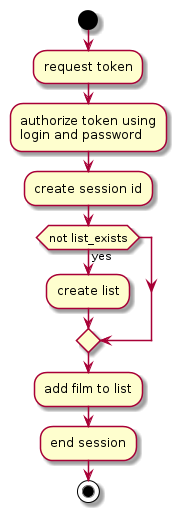